# Predictor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import IPython
import IPython.display

In [2]:
from preprocess.data_generator import WindowSplitter
from nn.deepar import create_model
from preprocess.data_generator import DatasetGenerator

In [3]:
CSV_FILE = "../data/data.csv"
df = pd.read_csv(CSV_FILE)
df = df.drop(columns=['t'])
df = df.replace(-255.0, np.nan)
df = df.interpolate('linear')
display(df[:3])
len(df)

,x,y,z,tx1,tx2,tx3,tx4,tx5,tx6,tx7,...,tx16,tx17,tx18,tx19,tx20,tx21,tx22,tx23,tx24,tx25
0,750.02,598.52,94.50,-55.0,-62.0,-67.0,-63.0,-66.0,-69.0,-67.0,...,-74.0,-72.0,-70.0,-69.0,-68.0,-67.0,-57.0,-53.0,-73.0,-61.0
1,759.46,579.46,94.11,-55.0,-63.0,-67.0,-63.0,-66.0,-68.0,-67.0,...,-77.0,-72.0,-66.0,-71.0,-57.0,-68.0,-62.0,-56.0,-74.0,-62.0
2,770.00,559.05,94.94,-56.0,-62.0,-60.0,-62.0,-58.0,-48.0,-66.0,...,-74.0,-71.0,-47.0,-70.0,-60.0,-65.0,-61.0,-51.0,-73.0,-62.0


16936

In [4]:
CHECKPOINT_PATH = "../checkpoints/deepar"

def restore_model(columns):
    model = create_model(dim_x=len(columns[3:]), dim_z=3)
    # restore checkpoints if exist
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
    return model
model = restore_model(columns=list(df.columns))

Restoring checkpoint from ../checkpoints/deepar\ckpt-90


In [5]:
class DataPreprocessor:
    def __init__(self, df, window_size=10):
        self.window_size = window_size
        self.input_window = []
        self.label_window = [] # OPTIONAL
        # the historical data used for getting the mean and variance
        self.df = df 
        self.epsilon = 1e-10
        mean, std = np.array(df.mean()), np.array(df.std())
        self.label_mean, self.label_std = mean[:3], std[:3] + self.epsilon
        self.input_mean, self.input_std = mean[3:], std[3:] + self.epsilon
    
    def add_input(self, data):
        # append data to data window
        self.input_window.append(data)
        # if window size exceed the data window size then
        # remove the first data
        if len(self.input_window) > self.window_size:
            self.input_window = self.input_window[1:]
            
    def add_label(self, data):
        # append data to data window
        self.label_window.append(data)
        # if window size exceed the data window size then
        # remove the first data
        if len(self.label_window) > self.window_size:
            self.label_window = self.label_window[1:]
            
    def get_input_tensor(self):
        if len(self.input_window) < 1:
            return None
        norm_input = (np.array(self.input_window) - self.input_mean) / self.input_std
        data = tf.convert_to_tensor([norm_input])
        # print(data)
        return data
    
    def get_label_tensor(self):
        if len(self.label_window) < 1:
            return None
        norm_input = (np.array(self.label_window) - self.label_mean) / self.label_std
        data = tf.convert_to_tensor([norm_input])
        # print(data)
        return data
        
    
    def summary(self):
        print(f'Label Mean: {self.label_mean}')
        print(f'Label Std: {self.label_std}')
        print(f'Input Std: {self.input_std}')
        print(f'Input Mean: {self.input_mean}')
        # print(f'Input Data: {self.input_window}')
        print(f'Input Tensor: {self.get_input_tensor()}')


prep = DataPreprocessor(df=df)
prep.summary()

Label Mean: [-39.31665151 -13.78704948  98.34586974]
Label Std: [525.48349342 519.45988678   2.80554326]
Input Std: [8.77779291 7.65567793 7.01089302 7.72872337 7.35515691 6.60713589
 7.7977597  7.45381677 7.89679985 7.47593647 6.49065042 7.29263745
 6.7509086  7.15662267 6.59754065 7.02084545 7.11768592 7.81508963
 6.47043901 6.87409206 6.46202452 7.50354804 6.57186798 6.92535359
 6.69965243]
Input Mean: [-64.38648441 -65.8654641  -65.72065423 -65.92639939 -64.98379192
 -67.41219887 -64.17843647 -65.57298063 -64.99876004 -66.77792867
 -67.99380019 -67.55907534 -67.21167926 -64.98954889 -67.09276098
 -67.57870808 -67.44535309 -66.71734766 -68.0119863  -67.55854393
 -67.64669934 -65.78451228 -67.7715222  -68.09866556 -67.77031176]
Input Tensor: None


In [7]:
def model_plot2D(model, prep, x_offset=0, y_offset=0, warmup_step = 0):
    plt.figure(figsize=(20,10))
    inputs = prep.get_input_tensor()
    labels = prep.get_label_tensor()
    means, _ = model(inputs)
    mean = (means[0, :] * prep.label_std + prep.label_mean) * 0.01
    label = (labels[0, :] * prep.label_std + prep.label_mean) * 0.01
    
    # Trajectory
    plt.scatter(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, s=10, marker='x', alpha=0.5)
    if labels is not None:
        plt.scatter(label[warmup_step:,0].numpy() + x_offset, label[warmup_step:,1].numpy() + y_offset, s=10, marker='.', alpha=0.5)
    
    # Last Point
    plt.scatter(mean[-1, 0].numpy() + x_offset, mean[-1, 1].numpy() + y_offset, s=30, marker='o', color='r')
    if labels is not None:
        plt.scatter(label[-1, 0].numpy() + x_offset, label[-1, 1].numpy() + y_offset, s=30, marker='x', color='g')

        
    plt.legend(labels=['Prediction', 'Ground Truth', 'Last Prediction', 'Last Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title('Prediction')
    plt.axis('equal')
    plt.show()
    
    return mean

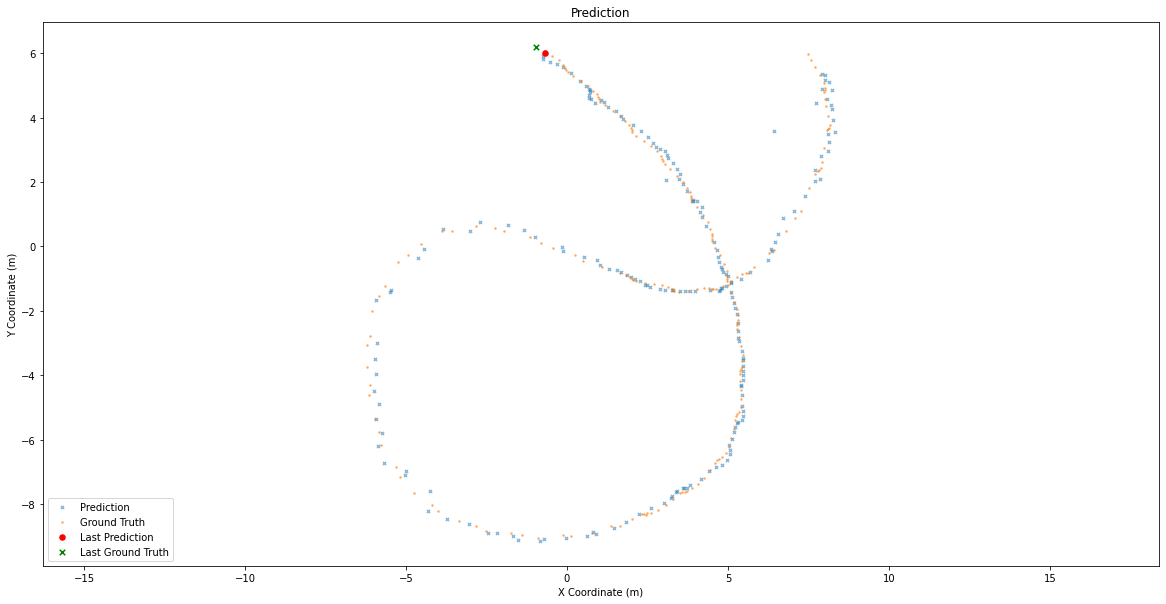

In [8]:
skip = 0
count = 200
prep = DataPreprocessor(df=df, window_size=300)

for index, row in df.iterrows():
    if index < skip:
        continue
    
    inputs,labels = list(row)[3:], list(row)[:3] 
    prep.add_input(inputs)
    prep.add_label(labels)
    
    # preview
    count -= 1
    if count < 0:
        # prep.summary()
        model_plot2D(model, prep)
        # print(mean[-1, :])
        break